# Grad Cam v1

In [1]:
from YOLOv8_Explainer import yolov8_heatmap, display_images
import matplotlib.pyplot as plt
from datasets import load_dataset
from matplotlib.pyplot import imshow
from ultralytics import YOLO

import cv2

In [8]:
# Initialize the YOLOv8 Explainer with Grad-CAM
model = yolov8_heatmap(
    weight="yolo_weights/yolov8SC.pt",  # Path to your YOLOv8 model weights
    conf_threshold=0.4,  # Confidence threshold for detections
    method="GradCAM",  # Use Grad-CAM instead of EigenCAM
    layer=[-3],  # Target layers for Grad-CAM
    ratio=0.005,  # Ratio for heatmap overlay
    show_box=True,  # Show bounding boxes on the image
    renormalize=False,  # Do not renormalize the heatmap
)
dataset = load_dataset("marmal88/skin_cancer")
test_split = dataset["test"]

label_mapping = {
    "melanoma": "Malignant",
    "melanocytic_Nevi": "Malignant",
    "dermatofibroma": "Benign",
    "basal_cell_carcinoma": "Malignant",
    "vascular_lesions": "Benign",
    "actinic_keratoses": "Malignant",
    "benign_keratosis-like_lesions": "Benign"
}

Model summary: 129 layers, 11,136,374 parameters, 0 gradients, 28.6 GFLOPs


In [4]:
true_positives = [4, 25, 29, 35, 37, 44, 53, 54, 55, 57]

Image 4
Image 25
Image 29
Image 35
Image 37
Image 44
Image 53
Image 54
Image 55
'int' object has no attribute 'backward'
Image 57


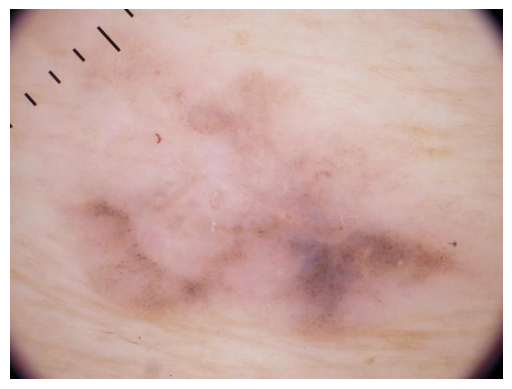

In [9]:

images = []
ground_truths = []
for i in true_positives:
    print(f"Image {i}")
    ground_truths.append(label_mapping[test_split[i]["dx"]])
    # Generate Grad-CAM heatmaps for an image
    try:
        images.append(model(
            img_path=f"true_positive_images/image_{i}.jpg",  # Path to your input image
        ))
    except Exception as e:
        print(f"Image {i} had the following error: {e}")
    img = cv2.imread(f"true_positive_images/image_{i}.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    # plt.show()

Image 0, with Ground Truth: Malignant


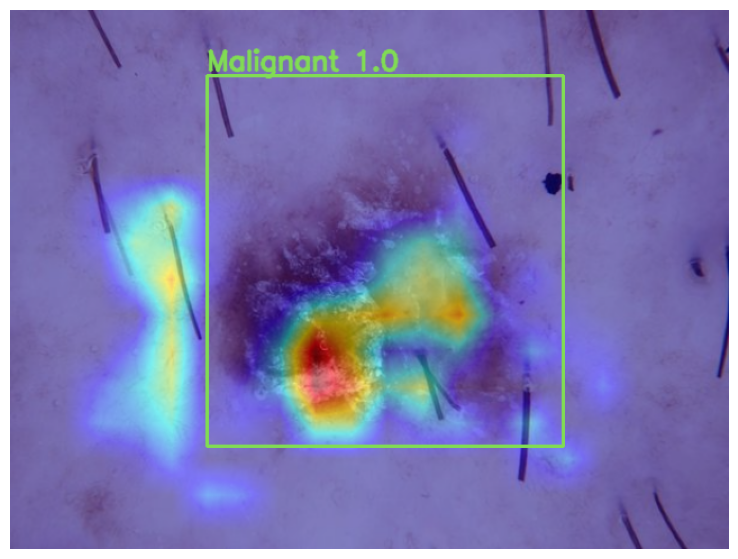

Image 4 displayed


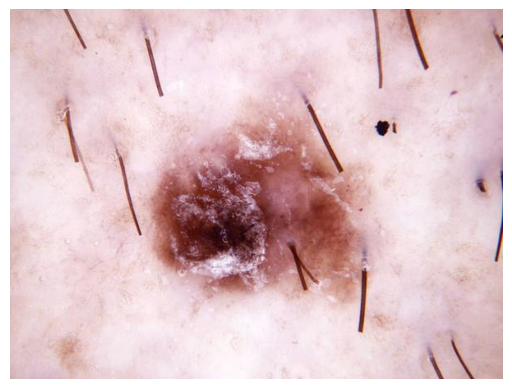

Image 1, with Ground Truth: Malignant


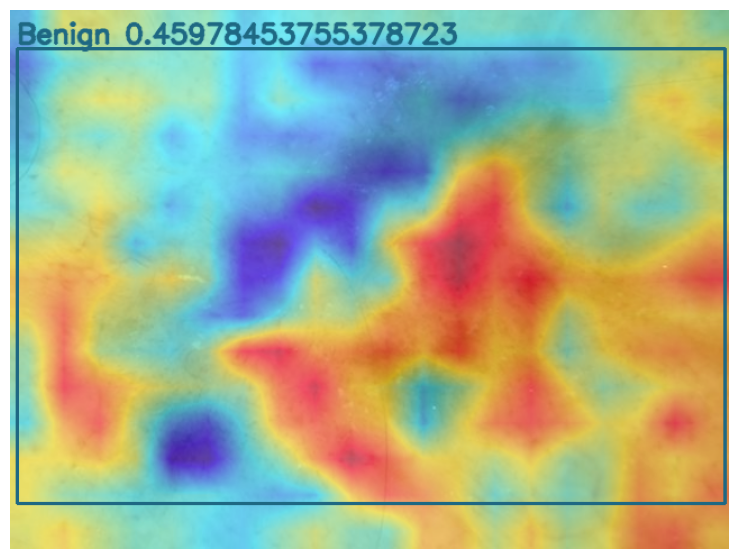

Image 25 displayed


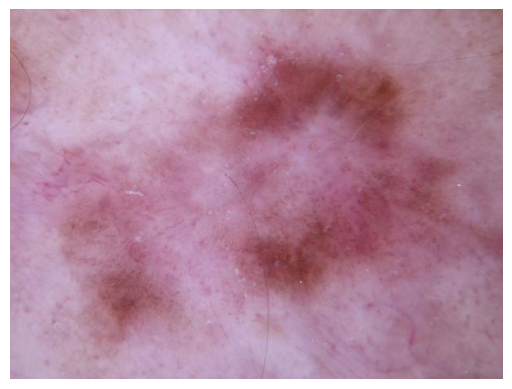

Image 2, with Ground Truth: Malignant


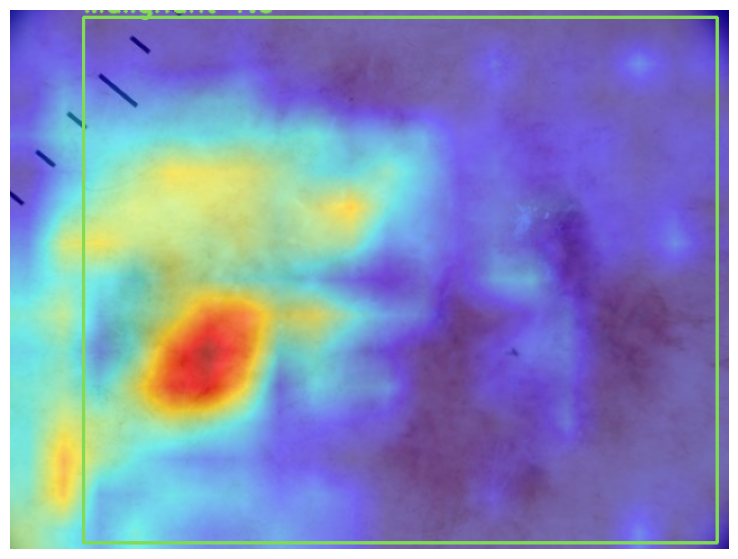

Image 29 displayed


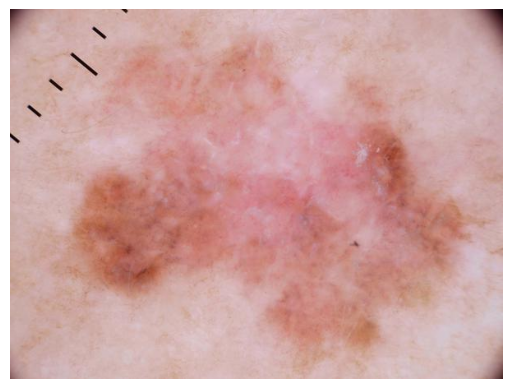

Image 3, with Ground Truth: Malignant


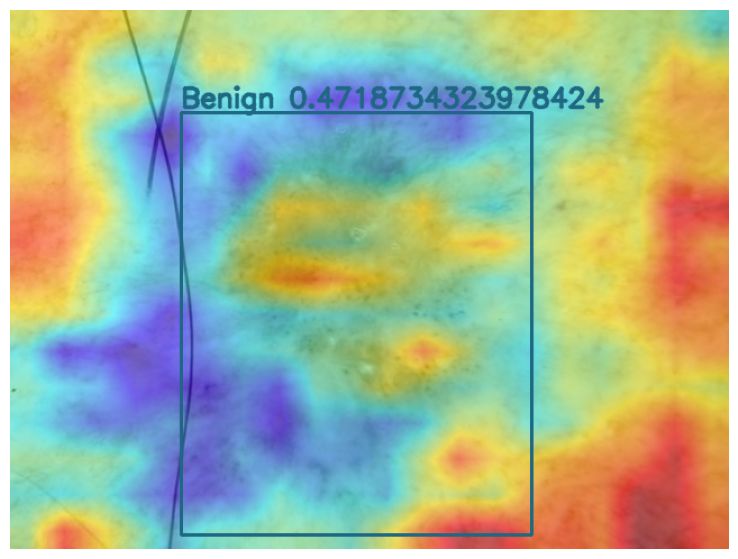

Image 35 displayed


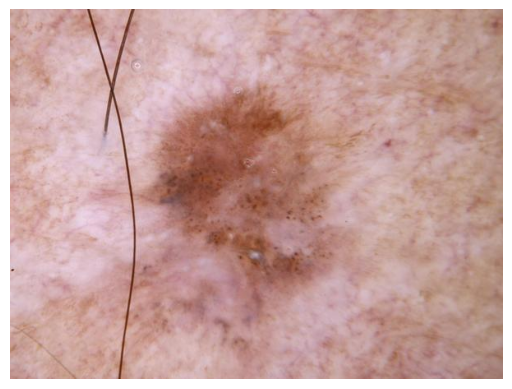

Image 4, with Ground Truth: Malignant


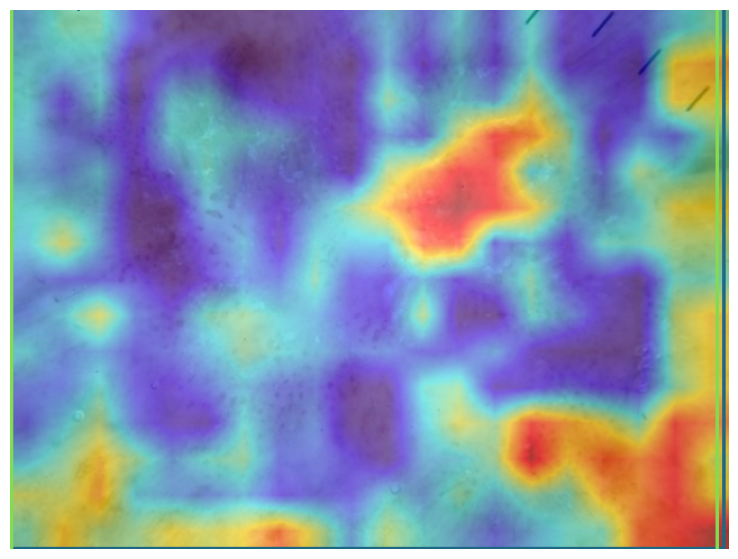

Image 37 displayed


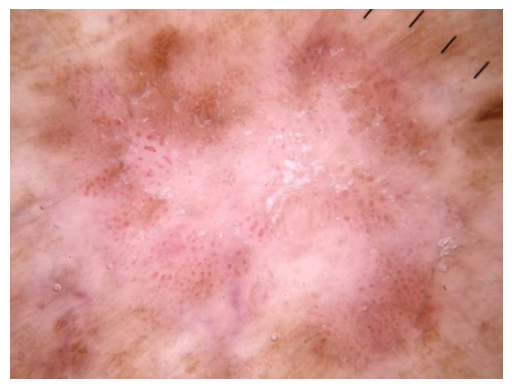

Image 5, with Ground Truth: Malignant


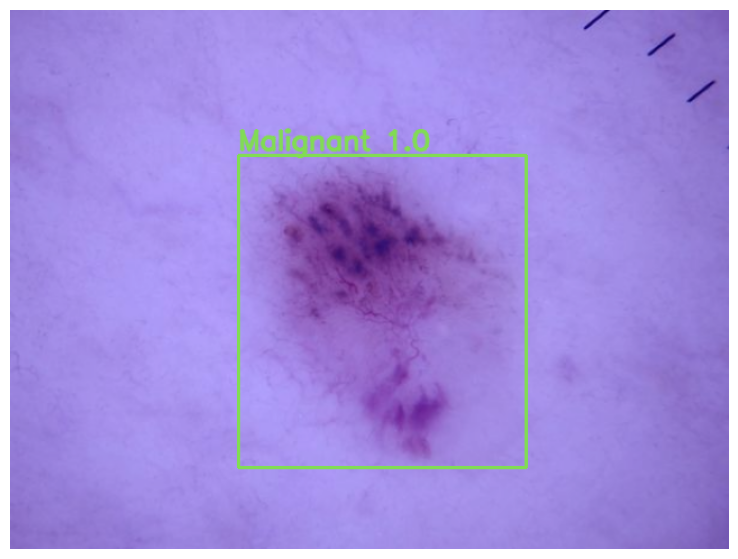

Image 44 displayed


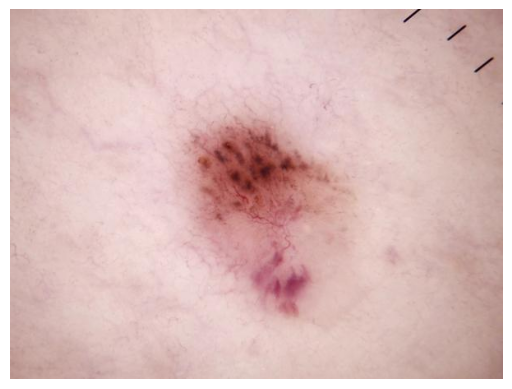

Image 6, with Ground Truth: Malignant


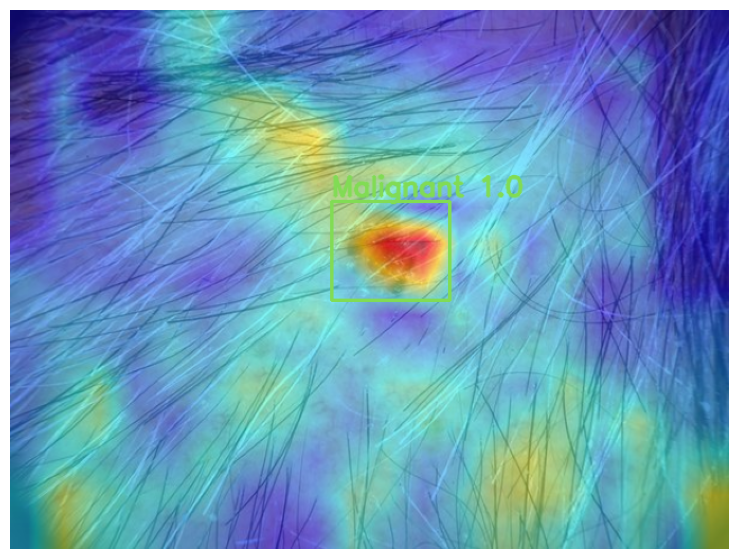

Image 53 displayed


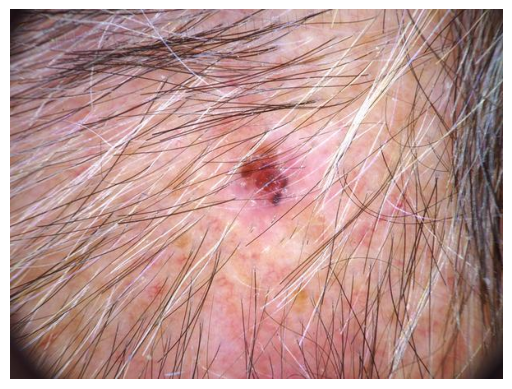

Image 7, with Ground Truth: Malignant


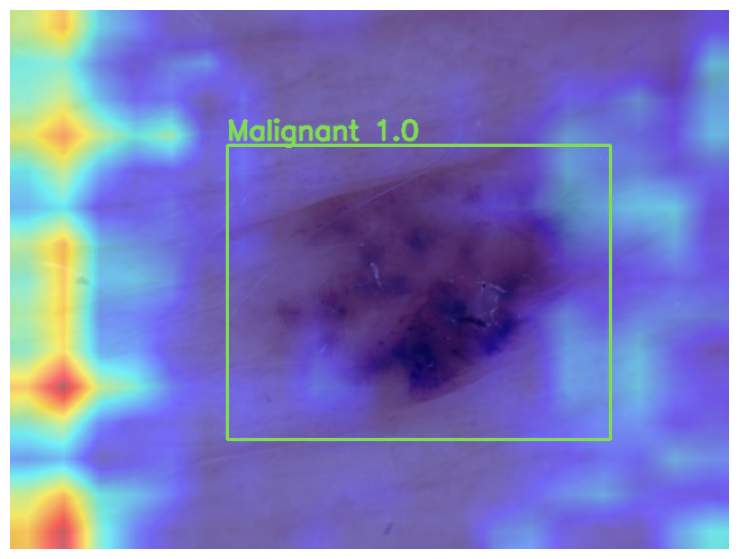

Image 54 displayed


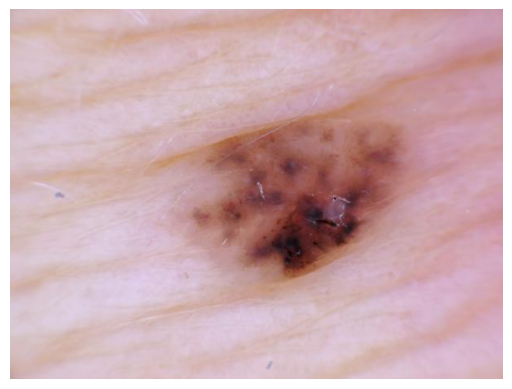

Image 9, with Ground Truth: Malignant


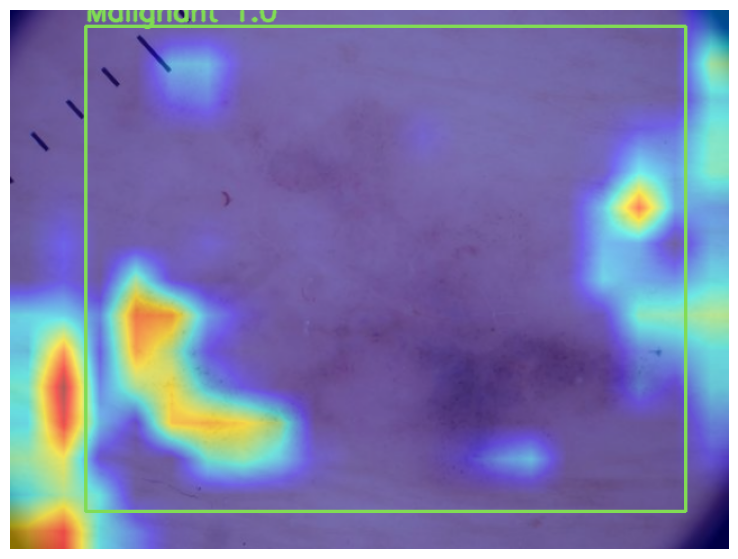

Image 57 displayed


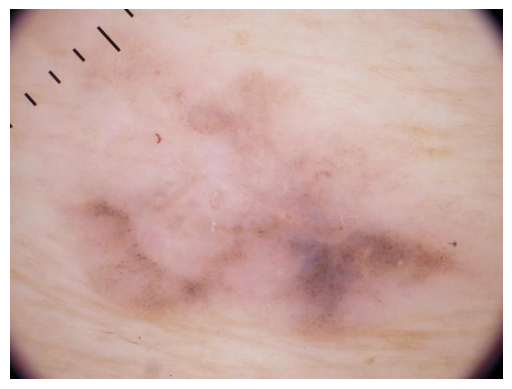

In [14]:
for i,image in enumerate(images):
    if (i == 8):
        continue

    print(f"Image {i}, with Ground Truth: {ground_truths[i]}")
    display_images(image)
    print(f"Image {true_positives[i]} displayed")
    img = cv2.imread(f"true_positive_images/image_{true_positives[i]}.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()



# Grad Cam v2


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

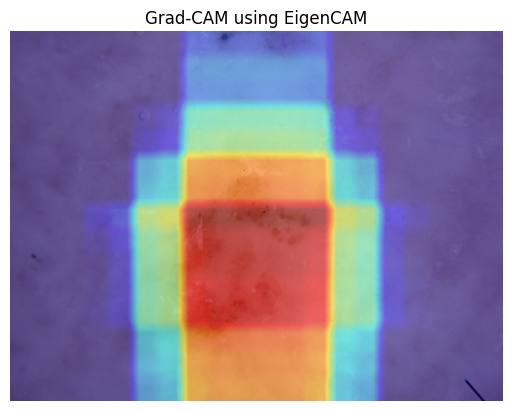

In [16]:
import torch
import numpy as np
import cv2
from ultralytics import YOLO
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

def preprocess_image(image):
    """Converts PIL Image to tensor and normalizes it."""
    image = image.convert("RGB")
    image = np.array(image)
    image = cv2.resize(image, (640, 640))  # Resize to YOLOv8 input size
    image = image / 255.0  # Normalize5
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    return image

# Load the YOLO model
model = YOLO("yolo_weights/yolov8SC.pt")  # Replace with your model path
model.eval()
print(model.model)

# Load dataset
dataset = load_dataset("marmal88/skin_cancer")
test_split = dataset["test"]

# Select a sample image from dataset
example = test_split[0]
image = example["image"]
rgb_img = np.array(image) / 255.0  # Normalize image for visualization
input_tensor = preprocess_image(image)

# Define target layers
target_layers = [model.model.model[10]]  # Adjust according to YOLOv8 model structure

# Apply EigenCAM
cam = EigenCAM(model, target_layers, task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
plt.imshow(cam_image)
plt.title("Grad-CAM using EigenCAM")
plt.axis("off")
plt.show()